<a href="https://colab.research.google.com/github/dssp-ethz/DSSP-Illustrations/blob/main/Trellis_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Viterbi Algorithm

Many optimization problems can be modelled using a Trellis diagram. In a Trellis diagram each path from the initial node (A) to the terminal node (K) uses the same number of branches. Thus the graph may be subdivided into several sections $n$ with a different set of branches. With the number of paths depending exponentially on $n$ (width of Trellis Diagram only changes base of exponentiation) finding the optimal path becomes infeasible in long Trellis Diagrams using an exhaustive search algorithm (brute force).

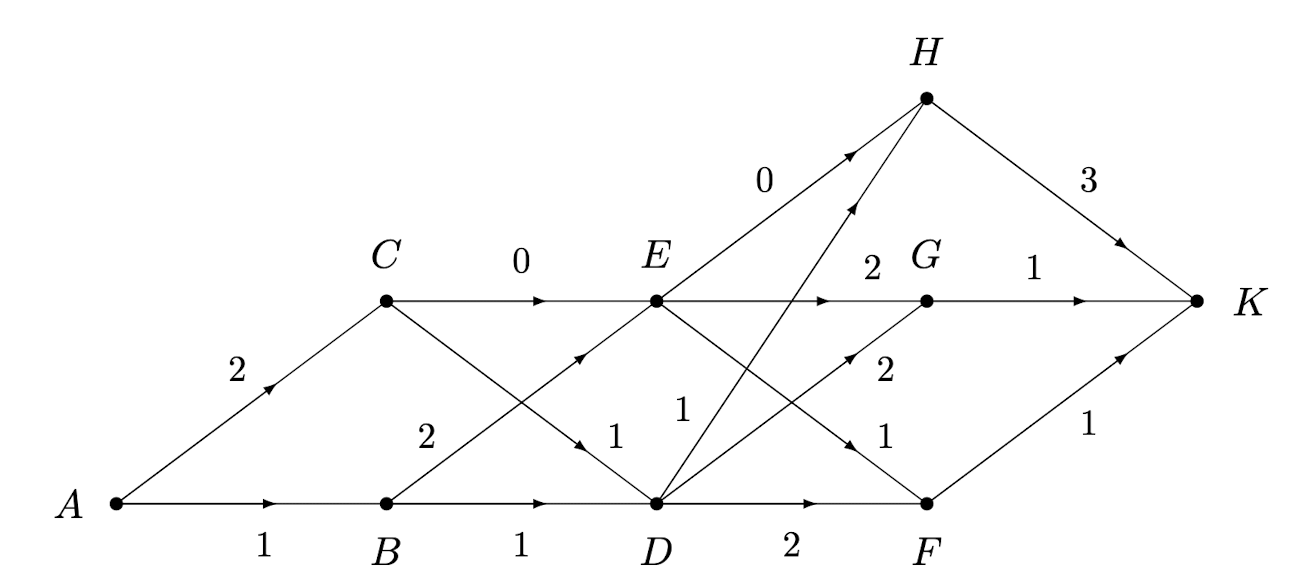

Lucky for us there is an algorithm, called Viterbi algorithm, which can compute the optimal path linearly in $n$. Viterbi algorithm is essentially Dijkstra's algorithm reduced to Trellis Diagrams (in case you know about the latter). Since it reuses past computations instead of repeating everything it is an example of dynamic programming. The viterbi algorithm is now presented:

**Viterbi Algorithm (min-sum version)**


*   **path metric** = sum of branch metrics
*   **initialization**: $\mu(s) = 0$ for all initial states $s$
*   **recursive computation of state metrics:**
    $\mu(s) = \min\limits_{\text{branches } b \text{ with } rst(b) = s} \mu(lst(b)) + \mu(b)$
    and recording the minimizing branch $b$ to each state $s$
*   **main property**: $\mu(s) =$ minimal path metric from any initial state to state $s$.





The code cell below implements the viterbi algorithm. It will be reused for the subsequent cells.

In [ ]:
import numpy as np

def viterbi(y, A, B, Pi=None):
    """
    Return the MAP estimate of state trajectory of Hidden Markov Model.

    Parameters
    ----------
    y : array (T,)
        Observation state sequence. int dtype.
    A : array (K, K)
        State transition matrix. See HiddenMarkovModel.state_transition  for
        details.
    B : array (K, M)
        Emission matrix. See HiddenMarkovModel.emission for details.
    Pi: optional, (K,)
        Initial state probabilities: Pi[i] is the probability x[0] == i. If
        None, uniform initial distribution is assumed (Pi[:] == 1/K).

    Returns
    -------
    x : array (T,)
        Maximum a posteriori probability estimate of hidden state trajectory,
        conditioned on observation sequence y under the model parameters A, B,
        Pi.
    T1: array (K, T)
        the probability of the most likely path so far
    T2: array (K, T)
        the x_j-1 of the most likely path so far
    """
    # Cardinality of the state space
    K = A.shape[0]
    # Initialize the priors with default (uniform dist) if not given by caller
    Pi = Pi if Pi is not None else np.full(K, 1 / K)
    T = len(y)
    T1 = np.empty((K, T), 'd')
    T2 = np.empty((K, T), 'B')

    # Initilaize the tracking tables from first observation
    T1[:, 0] = Pi * B[:, y[0]]
    T2[:, 0] = 0

    # Iterate throught the observations updating the tracking tables
    for i in range(1, T):
        T1[:, i] = np.max(T1[:, i - 1] * A.T * B[np.newaxis, :, y[i]].T, 1)
        T2[:, i] = np.argmax(T1[:, i - 1] * A.T, 1)

    # Build the output, optimal model trajectory
    x = np.empty(T, 'B')
    x[-1] = np.argmax(T1[:, T - 1])
    for i in reversed(range(1, T)):
        x[i - 1] = T2[x[i], i]

    return x, T1, T2

## Statistical Model

Let $W = (W_1, W_2, \ldots, W_n)$ be a random path (encded with edges) in a Trellis data structure. Assume we have an observation $Y_k$ for each section depending only on the chosen edge $W_k$ (i.i.d.). By giving the branches as weights the maximum likelihood estimate of $W_k$ the most likely random path is just the one which maximizes
$$f_{Y|W} (y|w) = \prod\limits_{k=1}^n f_{Y_k|W_k} (y_k|w_k)$$

### Problem 6.5 (as of 2020)

Let $y = (y_1, y_2, y_3, y_4, y_5)$ be a noisy version of a data file. We wish to reconstruct the original file $x=(x_1,x_2, x_3, x_4, x_5)\quad x_i \in \{0,1\}$. Luckily the original data has structure that introduces some redundancy. We shall use said redundancy to reconstruct the most likely data. We know that



1.   1 is always followed by 0
2.   single 0 is followed by 0 or 1 equiprobably
3.   Two zeros are always followed by 1
4.   $x_1$ is 0 or 1 equiprobably

From that we construct the trellis diagram:

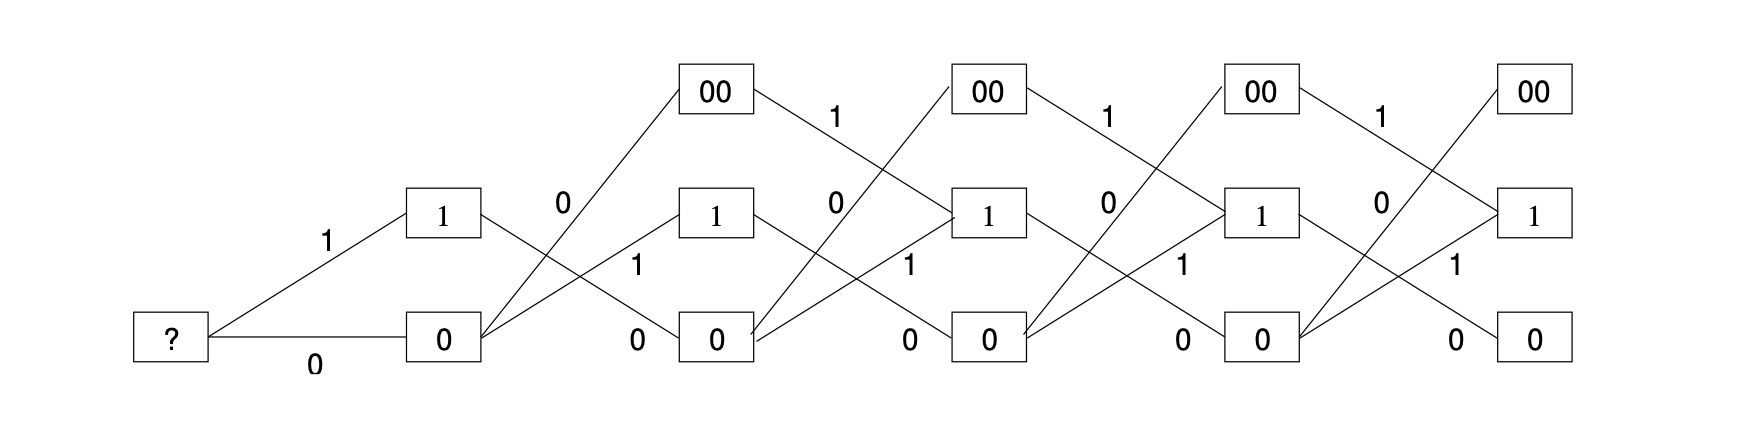

We assume $y$ was obtained from $x$ where each bit was independently flipped with probability $\epsilon$.
The following code snippet allows you to set all parameters of the task (make sure you enter 5 observed bits with white space between).

In [3]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#-------------------------------------------------------------------------------

#read in parameters
epsilonG = 0.1
yG = [0, 1, 1, 0, 0]
def update_parameters(epsilon, y):
  global epsilonG, yG
  try:
    y = [int(v) for v in y.split()]
    for e in y:
      if e != 0 and e != 1:
        raise #only bits allowed as observables
    epsilonG, yG = epsilon, y
  except:
    pass
widgets.interact(update_parameters, epsilon = widgets.FloatSlider(min=0, max=1, value=0.1), y = '0 1 1 0 0');

interactive(children=(FloatSlider(value=0.1, description='epsilon', max=1.0), Text(value='0 1 1 0 0', descript…

With these properties the statistical model is fairly simple. We have
$$f_{Y_k|X_k} (y_k|x_k) = \begin{cases} 1-\epsilon & y_k = x_k\\ \epsilon & y_k \neq x_k \end{cases}$$

The code snippet below runs the Viterbi algorithm for the established Trelli's diagram and statistical model to get the most likely original data. What do you notice if you increase $\epsilon$?.